In [1]:
import pickle
import numpy as np
from rul_calce_data import individual_battery_run 
from utility import cal_ttf

def rul_battery(t, y, name):
    # Calculate true TTF.
    threshold = .7*1.1
    true_ttf, idx_ttf = cal_ttf(t, y, threshold)
    t = t[:idx_ttf+10]
    y = y[:idx_ttf+10]
    T = len(t) # Number of time steps
    
    # Define the Parameters.
    # For the PF.
    sigma_u = np.array([1e-2, 1e-5, 1e-4, 1e-3])
    sigma_v = 1e-2
    Ns = 1e3
    # For the RUL prediction.
    max_RUL = 600 # RUL when not failure found.
    idx_start = 300
    step = 10
    idx_pred = np.arange(idx_ttf-idx_start, idx_ttf+step, step, dtype=int) # Index of the prediction instants.
    
    xh, yh, y_bands, rul_mean, rul_bands, rul, rul_weights, pf = individual_battery_run(t, y, sigma_u, sigma_v, Ns, threshold, idx_ttf, idx_pred, max_RUL, n_plt=10)

    # Save the result.
    file_name = 'result_' + name + '.pickle'
    with open(file_name, 'wb') as f:
        pickle.dump([t, y, threshold, idx_ttf, idx_pred, true_ttf, max_RUL, 
            xh, yh, y_bands, rul_mean, rul_bands, rul, rul_weights, pf.particles, pf.w
        ], f, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
# Run particle filtering to estimate the state variables.
battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
# Directly read from the archived data.
with open('data_all.pickle', 'rb') as f:
    data_all = pickle.load(f)

# CS2_35

In [3]:
# from utility import drop_outlier_sw
# from utility import cal_ttf

# name = battery_list[0]
# battery = data_all[name]
# battery.fillna(method='ffill', inplace=True)
# # Get the time and degradation measurement. Perform filtering.
# t = battery['cycle']
# y = battery['discharging capacity']
# # t = np.array(t)
# # y = np.array(y)

# rolling_window = 20
# idx = drop_outlier_sw(y, rolling_window)
# t = np.array(t[idx])
# y = np.array(y[idx])

# rul_battery(t, y, name)

  0%|          | 0/31 [00:00<?, ?it/s]c:\Users\Zhiguo\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\Zhiguo\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
100%|██████████| 31/31 [00:04<00:00,  6.21it/s]


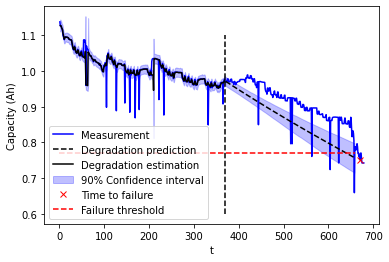

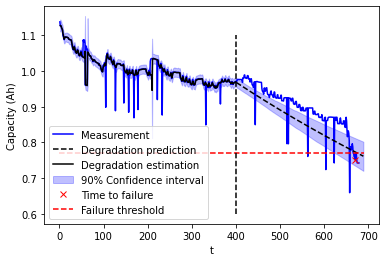

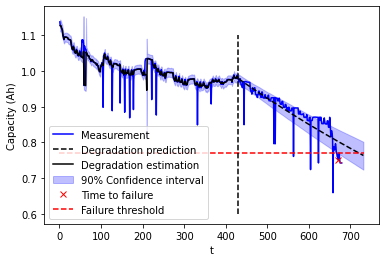

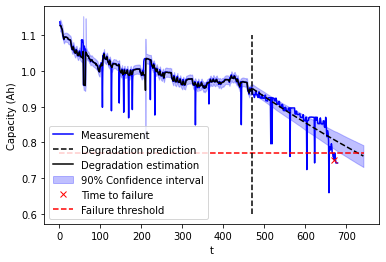

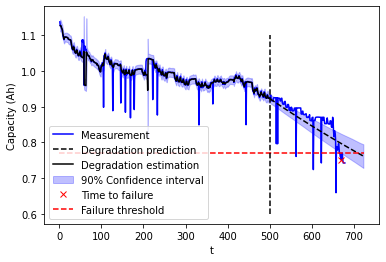

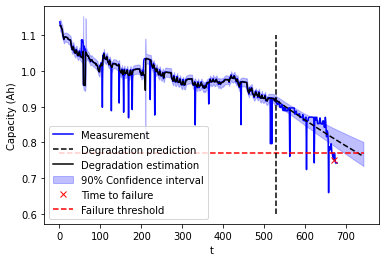

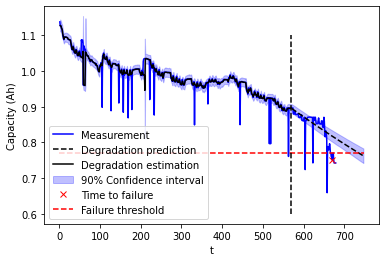

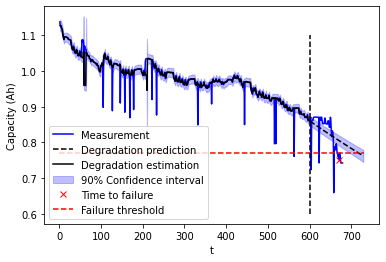

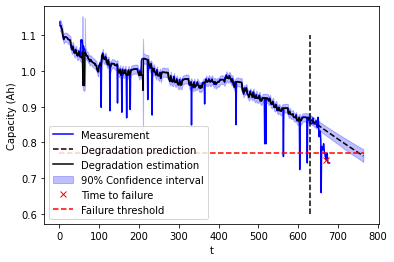

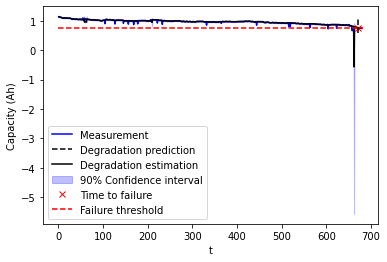

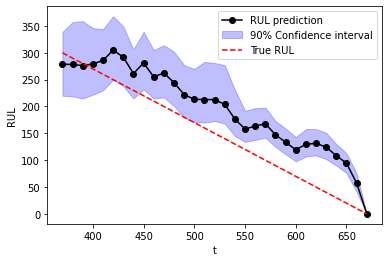

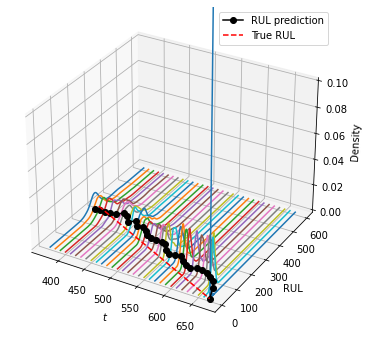

In [4]:
# Without explicit filtering.

name = battery_list[0]
battery = data_all[name]
battery.fillna(method='ffill', inplace=True)
# Get the time and degradation measurement. Perform filtering.
t = battery['cycle']
y = battery['discharging capacity']
t = np.array(t)
y = np.array(y)

rul_battery(t, y, name)

# CS2_36

In [5]:
# from utility import drop_outlier_sw

# name = battery_list[1]
# battery = data_all[name]
# # Get the time and degradation measurement. Perform filtering.
# t = battery['cycle']
# y = battery['discharging capacity']
# # t = np.array(t)
# # y = np.array(y)

# rolling_window = 20
# idx = drop_outlier_sw(y, rolling_window)
# t = np.array(t[idx])
# y = np.array(y[idx])

# rul_battery(t, y, name)

100%|██████████| 31/31 [00:04<00:00,  6.96it/s]


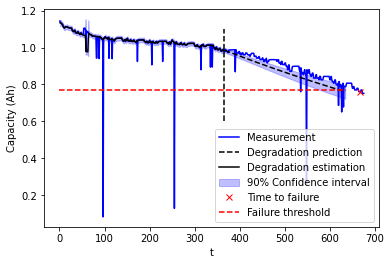

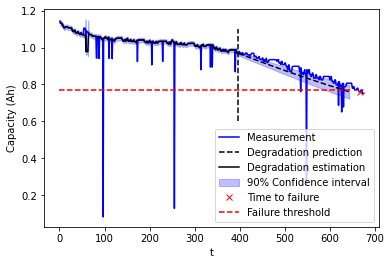

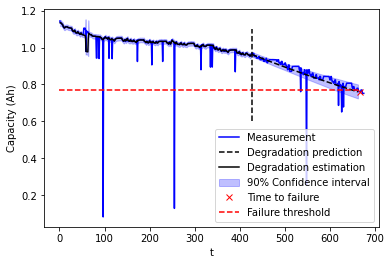

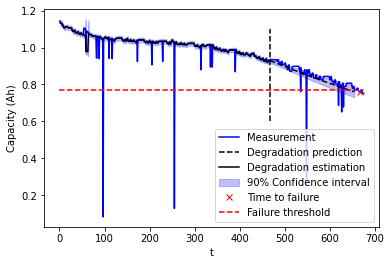

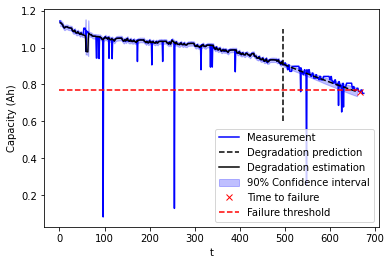

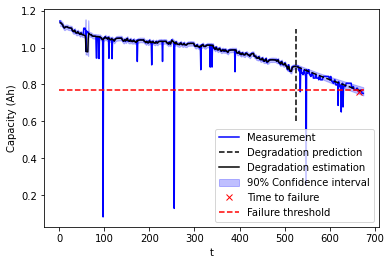

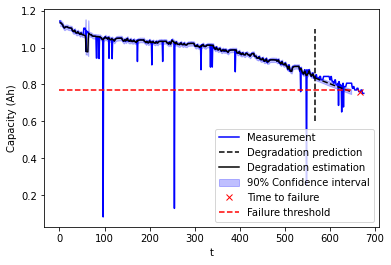

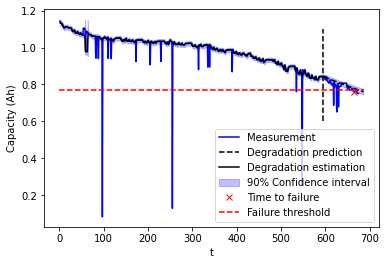

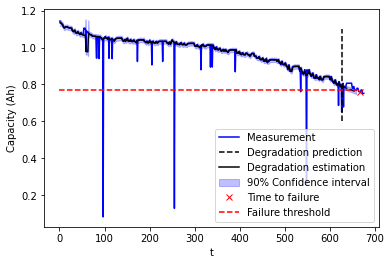

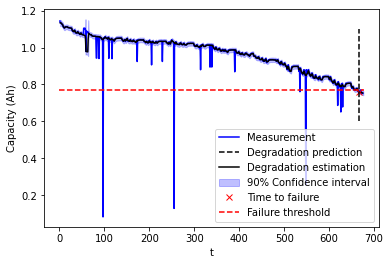

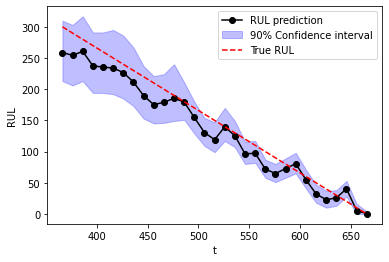

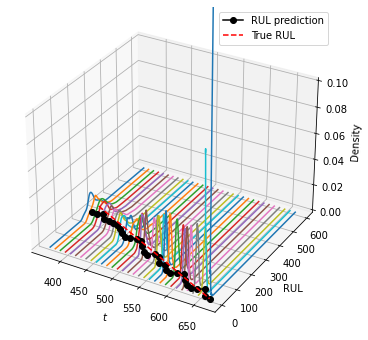

In [6]:
# Without explicit filtering.

name = battery_list[1]
battery = data_all[name]
battery.fillna(method='ffill', inplace=True)
# Get the time and degradation measurement. Perform filtering.
t = battery['cycle']
y = battery['discharging capacity']
t = np.array(t)
y = np.array(y)

rul_battery(t, y, name)

# CS_37

In [7]:
# from utility import drop_outlier_sw

# name = battery_list[2]
# battery = data_all[name]
# # Get the time and degradation measurement. Perform filtering.
# t = battery['cycle']
# y = battery['discharging capacity']
# # t = np.array(t)
# # y = np.array(y)

# rolling_window = 20
# idx = drop_outlier_sw(y, rolling_window)
# t = np.array(t[idx])
# y = np.array(y[idx])

# rul_battery(t, y, name)

100%|██████████| 31/31 [00:04<00:00,  7.33it/s]


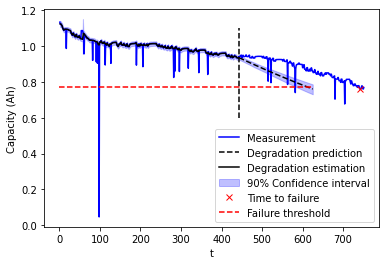

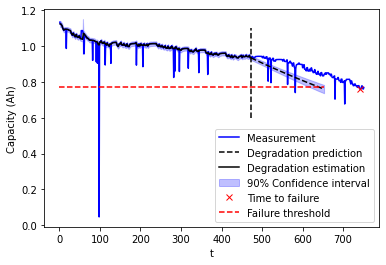

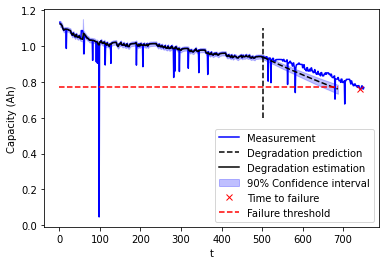

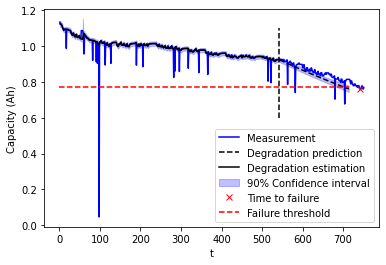

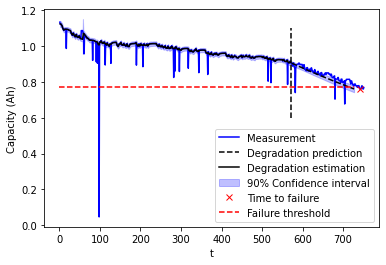

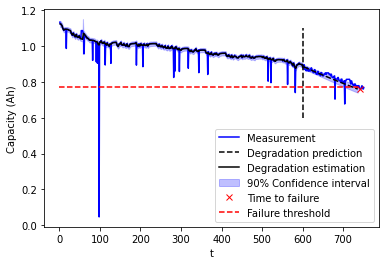

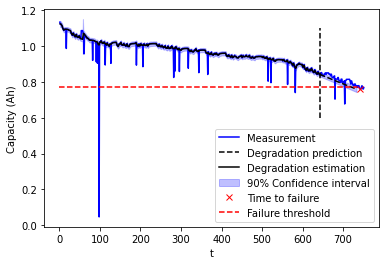

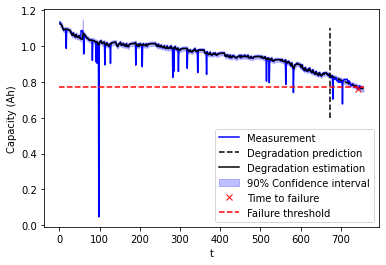

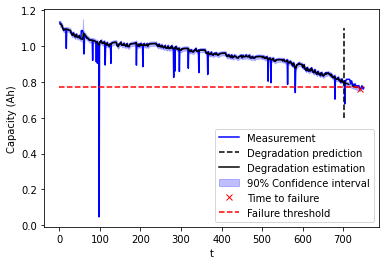

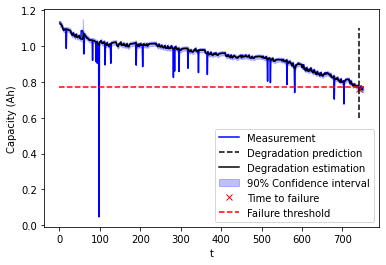

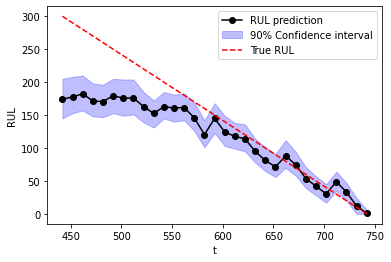

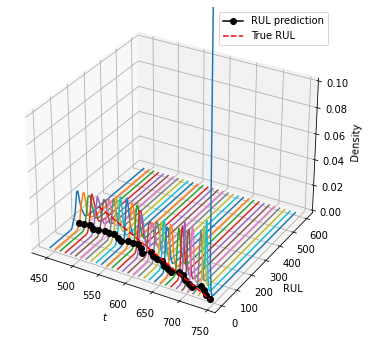

In [8]:
# Without explicit filtering.

name = battery_list[2]
battery = data_all[name]
battery.fillna(method='ffill', inplace=True)
# Get the time and degradation measurement. Perform filtering.
t = battery['cycle']
y = battery['discharging capacity']
t = np.array(t)
y = np.array(y)

rul_battery(t, y, name)

# CS_38

In [9]:
# from utility import drop_outlier_sw

# name = battery_list[3]
# battery = data_all[name]
# # Get the time and degradation measurement. Perform filtering.
# t = battery['cycle']
# y = battery['discharging capacity']
# # t = np.array(t)
# # y = np.array(y)

# rolling_window = 20
# idx = drop_outlier_sw(y, rolling_window)
# t = np.array(t[idx])
# y = np.array(y[idx])

# rul_battery(t, y, name)

100%|██████████| 31/31 [00:04<00:00,  7.38it/s]


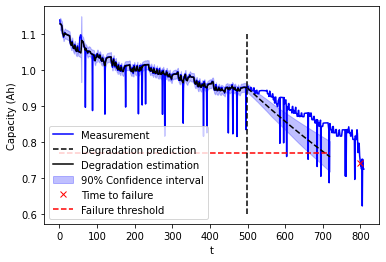

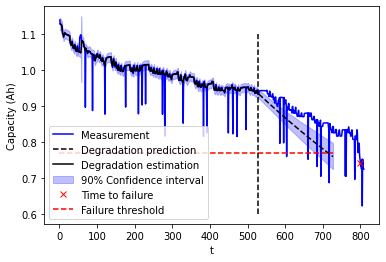

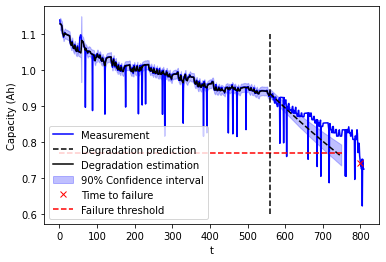

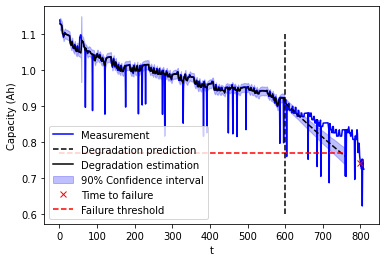

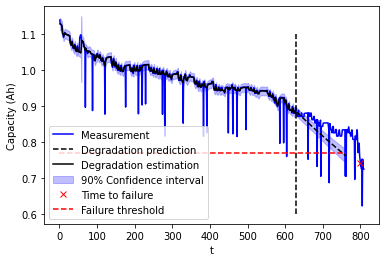

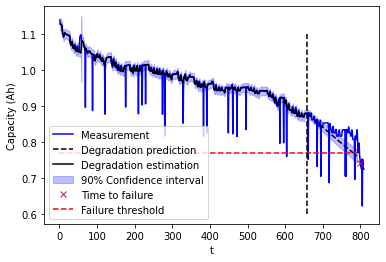

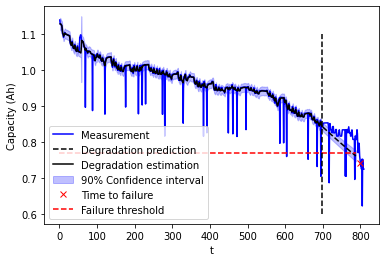

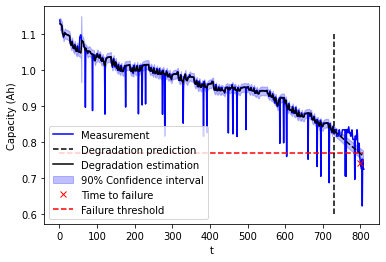

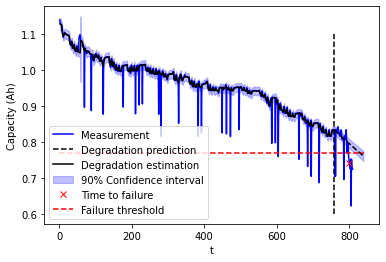

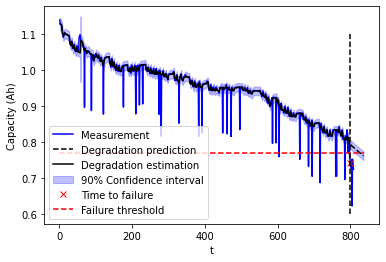

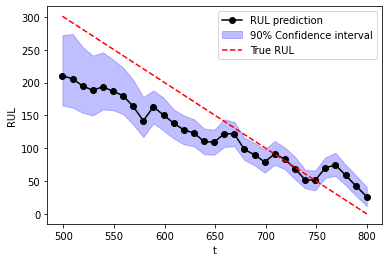

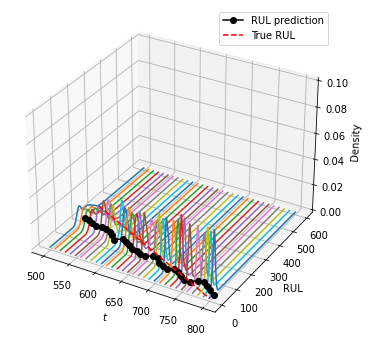

In [10]:
# Without explicit filtering.

name = battery_list[3]
battery = data_all[name]
battery.fillna(method='ffill', inplace=True)
# Get the time and degradation measurement. Perform filtering.
t = battery['cycle']
y = battery['discharging capacity']
t = t[y>.2]
y = y[y>.2]
t = np.array(t)
y = np.array(y)

rul_battery(t, y, name)

# 0.5 C.
## CS_33

In [11]:
# Run particle filtering to estimate the state variables.
battery_list = ['CS2_33', 'CS2_34']
# Directly read from the archived data.
with open('data_all_halfC.pickle', 'rb') as f:
    data_all = pickle.load(f)

In [12]:
# from utility import drop_outlier_sw
# from utility import cal_ttf

# name = battery_list[0]
# battery = data_all[name]
# # Get the time and degradation measurement. Perform filtering.
# t = battery['cycle']
# y = battery['discharging capacity']
# # t = np.array(t)
# # y = np.array(y)

# rolling_window = 20
# idx = drop_outlier_sw(y, rolling_window)
# t = np.array(t[idx])
# y = np.array(y[idx])

# rul_battery(t, y, name)

  0%|          | 0/31 [00:00<?, ?it/s]c:\Users\Zhiguo\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
  3%|▎         | 1/31 [00:00<00:05,  5.24it/s]c:\Users\Zhiguo\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
100%|██████████| 31/31 [00:04<00:00,  6.36it/s]


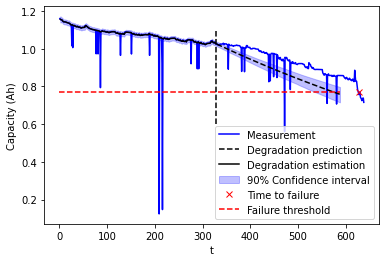

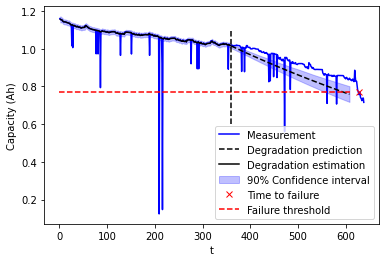

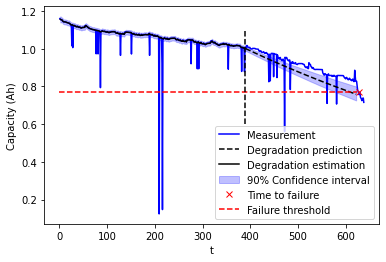

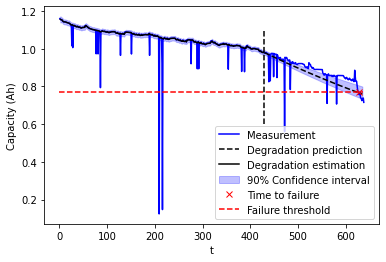

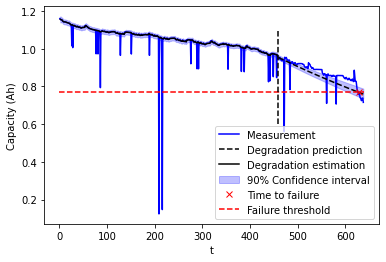

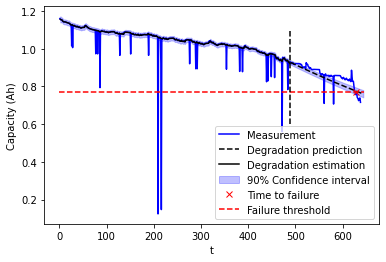

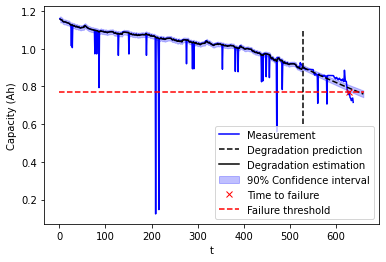

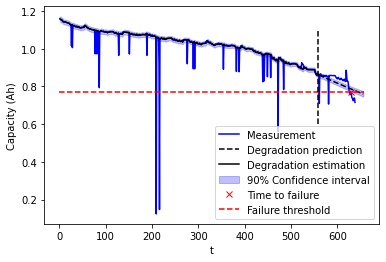

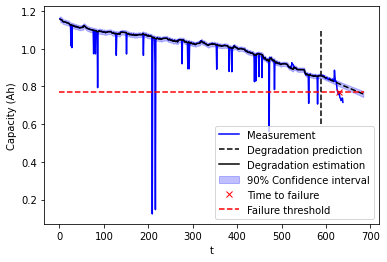

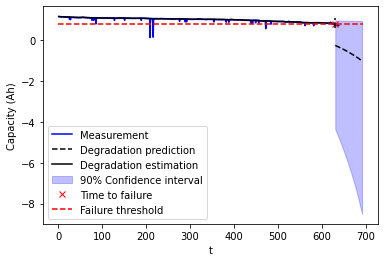

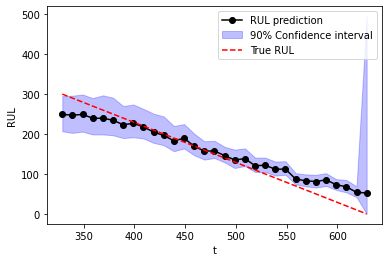

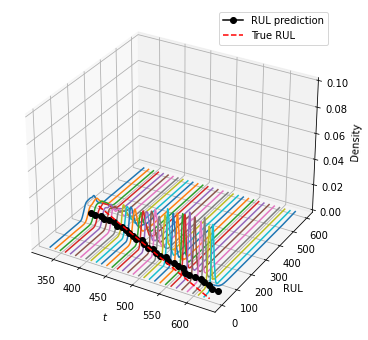

In [13]:
# Without explicit filtering.

name = battery_list[0]
battery = data_all[name]
battery.fillna(method='ffill', inplace=True)
# Get the time and degradation measurement. Perform filtering.
t = battery['cycle']
y = battery['discharging capacity']
t = np.array(t)
y = np.array(y)

rul_battery(t, y, name)

## CS2_34

In [14]:
# from utility import drop_outlier_sw
# from utility import cal_ttf

# name = battery_list[1]
# battery = data_all[name]
# # Get the time and degradation measurement. Perform filtering.
# t = battery['cycle']
# y = battery['discharging capacity']
# # t = np.array(t)
# # y = np.array(y)

# rolling_window = 20
# idx = drop_outlier_sw(y, rolling_window)
# t = np.array(t[idx])
# y = np.array(y[idx])

# rul_battery(t, y, name)

100%|██████████| 31/31 [00:05<00:00,  5.28it/s]


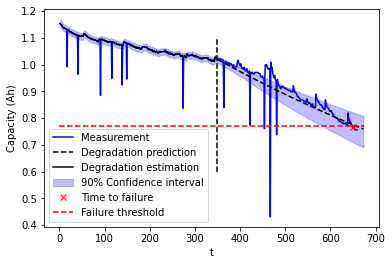

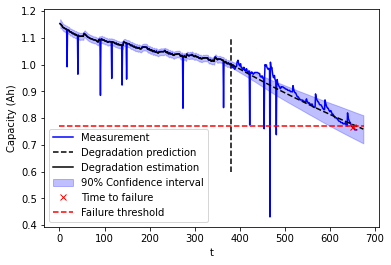

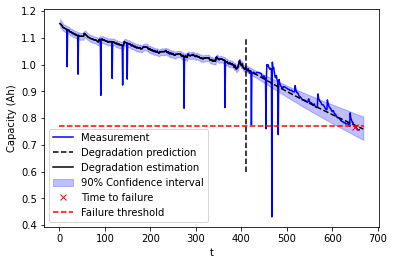

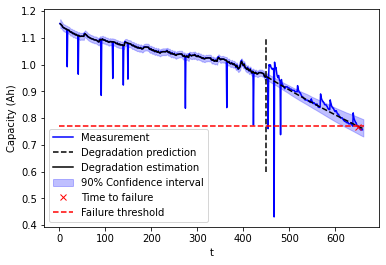

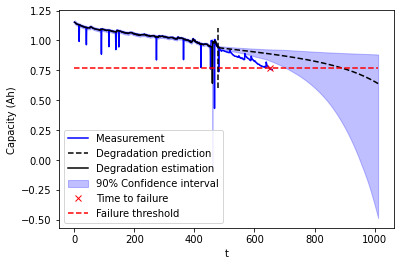

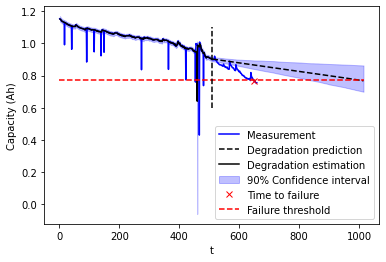

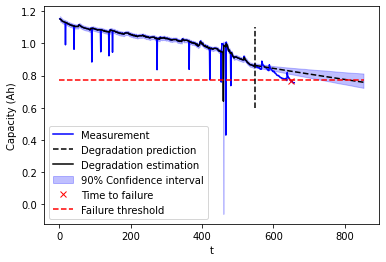

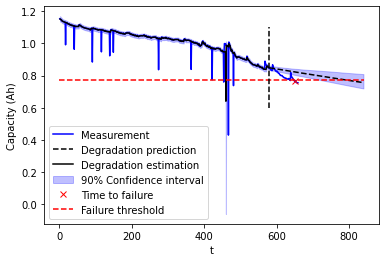

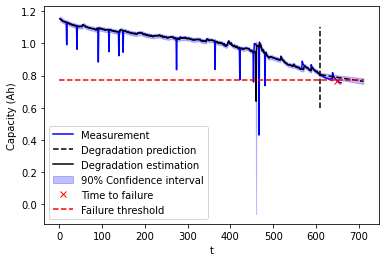

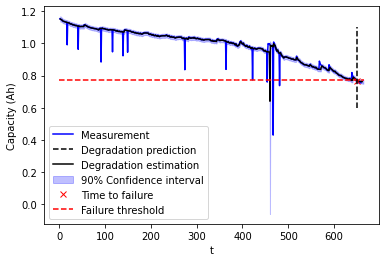

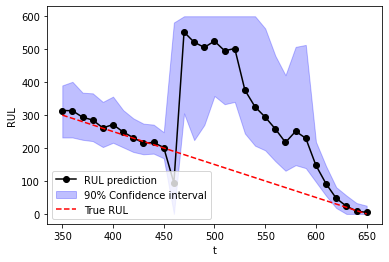

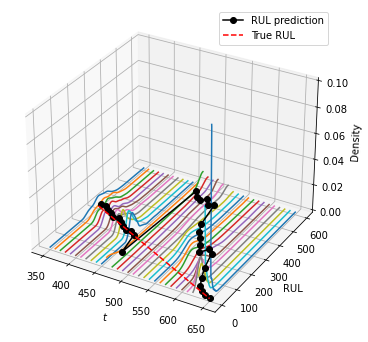

In [15]:
# Without explicit filtering.

name = battery_list[1]
battery = data_all[name]
battery.fillna(method='ffill', inplace=True)
# Get the time and degradation measurement. Perform filtering.
t = battery['cycle']
y = battery['discharging capacity']
t = np.array(t)
y = np.array(y)

rul_battery(t, y, name)